# Smart Budget Planner - Data Analysis

**Project:** November 2025 Data Science & Software Engineering Code Jam  
**Branch:** viktor-dev

## Project Overview

This notebook contains the data analysis for the **Smart Budget Planner** application. The goal is to analyze spending behavior across multiple users and create benchmark data that helps individuals compare their spending to population averages.

## Objectives

1. **Aggregate Spending by Category** - Clean and summarize transaction data
2. **Build Benchmarks** - Calculate average and median spending per category
3. **Compare Individual to Population** - Identify spending patterns and outliers
4. **Visualize Insights** - Create charts for user comparison
5. **Forecast Trends** - Predict future spending using regression

## Dataset

- **Source:** Kaggle Transactions Dataset
- **Size:** 7.4 million transactions
- **Time Period:** September - October 2024
- **Categories:** Healthcare, Restaurant, Entertainment, Retail, Travel, Gas, Grocery, Education

## Deliverables

- `benchmark_spending.json` - Average and median spending by category for SE team
- This Jupyter Notebook - Complete analysis with visualizations
- Written report - Findings and methodology

## Part 1: Data Loading & Exploration

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [297]:
df = pd.read_csv("../data.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst 5 rows:")
display(df.head())
print(f"\nData types:")
display(df.dtypes)
print(f"\nMissing values:")
display(df.isnull().sum())

Dataset shape: (7483766, 24)

Column names:
['transaction_id', 'customer_id', 'card_number', 'timestamp', 'merchant_category', 'merchant_type', 'merchant', 'amount', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'device_fingerprint', 'ip_address', 'distance_from_home', 'high_risk_merchant', 'transaction_hour', 'weekend_transaction', 'velocity_last_hour', 'is_fraud']

First 5 rows:


,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True



Data types:


transaction_id          object
customer_id             object
card_number              int64
timestamp               object
merchant_category       object
merchant_type           object
merchant                object
amount                 float64
currency                object
country                 object
city                    object
city_size               object
card_type               object
card_present              bool
device                  object
channel                 object
device_fingerprint      object
ip_address              object
distance_from_home       int64
high_risk_merchant        bool
transaction_hour         int64
weekend_transaction       bool
velocity_last_hour      object
is_fraud                  bool
dtype: object


Missing values:


transaction_id         0
customer_id            0
card_number            0
timestamp              0
merchant_category      0
merchant_type          0
merchant               0
amount                 0
currency               0
country                0
city                   0
city_size              0
card_type              0
card_present           0
device                 0
channel                0
device_fingerprint     0
ip_address             0
distance_from_home     0
high_risk_merchant     0
transaction_hour       0
weekend_transaction    0
velocity_last_hour     0
is_fraud               0
dtype: int64

In [298]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', utc=True)
df_clean = df.dropna(subset=['amount', 'merchant_category']).copy()
df_clean = df_clean[df_clean['amount'] > 0].copy()


We begin by ensuring data quality through basic validation steps:
1. Convert timestamps to datetime format for temporal analysis.
2. Remove rows with missing amounts or merchant categories.
3. Filter out negative or zero transaction amounts to ensure realistic spending data.

In [299]:
# Add month/year columns for aggregation
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['year_month'] = df_clean['timestamp'].dt.tz_localize(None).dt.to_period('M')

print("Date columns added successfully!")
display(df_clean[['timestamp', 'year', 'month', 'year_month', 'merchant_category', 'amount']].head(10))

Date columns added successfully!


,timestamp,year,month,year_month,merchant_category,amount
0,2024-09-30 00:00:01.034820+00:00,2024,9,2024-09,Restaurant,294.87
1,2024-09-30 00:00:01.764464+00:00,2024,9,2024-09,Entertainment,3368.97
2,2024-09-30 00:00:02.273762+00:00,2024,9,2024-09,Grocery,102582.38
3,2024-09-30 00:00:02.297466+00:00,2024,9,2024-09,Gas,630.60
4,2024-09-30 00:00:02.544063+00:00,2024,9,2024-09,Healthcare,724949.27
5,2024-09-30 00:00:03.050458+00:00,2024,9,2024-09,Education,11.76
6,2024-09-30 00:00:03.149440+00:00,2024,9,2024-09,Grocery,2606.19
7,2024-09-30 00:00:06.295911+00:00,2024,9,2024-09,Travel,828.33
8,2024-09-30 00:00:06.813965+00:00,2024,9,2024-09,Healthcare,104921.00
9,2024-09-30 00:00:07.105592+00:00,2024,9,2024-09,Retail,51521.84


In [300]:
# Monthly spending by category
monthly_spending = df_clean.groupby(['year_month', 'merchant_category'])['amount'].sum().reset_index()
print("\nMonthly Spending Comparison:")
display(monthly_spending.pivot(index='merchant_category', columns='year_month', values='amount').fillna(0))

# Add day column for forecasting
df_clean['day'] = df_clean['timestamp'].dt.date


Monthly Spending Comparison:


year_month,2024-09,2024-10
merchant_category,,
Education,1.365454e+09,4.069934e+10
Entertainment,8.847384e+08,2.610591e+10
Gas,1.381400e+09,4.101196e+10
Grocery,1.072701e+09,3.202950e+10
Healthcare,1.366582e+09,4.067970e+10
Restaurant,7.881954e+08,2.364021e+10
Retail,1.876147e+09,5.472766e+10
Travel,2.863121e+09,8.816450e+10


### Date Feature Engineering
Extract temporal features (year, month, year_month) from timestamps to enable time-based aggregation and filtering.

## Part 2: Data Cleaning & Preparation

In [301]:
print("Dataset Info:")
df.info()

print("Statistical Summary:")
display(df.describe())

print("Unique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 24 columns):
 #   Column               Dtype              
---  ------               -----              
 0   transaction_id       object             
 1   customer_id          object             
 2   card_number          int64              
 3   timestamp            datetime64[ns, UTC]
 4   merchant_category    object             
 5   merchant_type        object             
 6   merchant             object             
 7   amount               float64            
 8   currency             object             
 9   country              object             
 10  city                 object             
 11  city_size            object             
 12  card_type            object             
 13  card_present         bool               
 14  device               object             
 15  channel              object             
 16  device_fingerprint   object             

,card_number,amount,distance_from_home,transaction_hour
count,7.483766e+06,7.483766e+06,7.483766e+06,7.483766e+06
mean,4.222100e+15,4.792468e+04,3.220519e-01,1.215467e+01
std,2.341170e+15,1.775562e+05,4.672628e-01,6.536767e+00
min,3.700086e+14,1.000000e-02,0.000000e+00,0.000000e+00
25%,4.004400e+15,3.635300e+02,0.000000e+00,7.000000e+00
50%,5.010745e+15,1.177450e+03,0.000000e+00,1.200000e+01
75%,5.999914e+15,2.242953e+04,1.000000e+00,1.800000e+01
max,6.999728e+15,6.253153e+06,1.000000e+00,2.300000e+01


Unique values per column:
transaction_id: 7477306 unique values
customer_id: 4869 unique values
card_number: 5000 unique values
timestamp: 7483754 unique values
merchant_category: 8 unique values
merchant_type: 17 unique values
merchant: 105 unique values
amount: 2831167 unique values
currency: 11 unique values
country: 12 unique values
city: 11 unique values
city_size: 2 unique values
card_type: 5 unique values
card_present: 2 unique values
device: 9 unique values
channel: 3 unique values
device_fingerprint: 785462 unique values
ip_address: 7477187 unique values
distance_from_home: 2 unique values
high_risk_merchant: 2 unique values
transaction_hour: 24 unique values
weekend_transaction: 2 unique values
velocity_last_hour: 7483740 unique values
is_fraud: 2 unique values


### Exploratory Data Analysis
Examine the raw dataset structure, data types, statistical distributions, and cardinality of each column to understand the data before processing.

In [302]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', utc=True)

# Remove any rows with missing critical values
df_clean = df.dropna(subset=['amount', 'merchant_category']).copy()

# Ensure amount is numeric and positive
df_clean = df_clean[df_clean['amount'] > 0].copy()

# Remove fraudulent transactions
df_clean = df_clean[df_clean['is_fraud'] == False].copy()

# Parse dates and extract month
df_clean['month'] = df_clean['timestamp'].dt.month

# Remove October data completely
df_clean = df_clean[df_clean['month'] == 9]

print(f"September data only: {len(df_clean):,} rows")

# Aggregate by customer and category for the month
print("\nAggregating by customer and category...")
customer_category_spending = df_clean.groupby(
    ['customer_id', 'merchant_category']
)['amount'].sum().reset_index()

print(f"Customer-category combinations: {len(customer_category_spending):,}")

# Remove extreme outliers
print("\nRemoving customers with >$10,000 monthly spending per category...")
customer_category_spending = customer_category_spending[
    customer_category_spending['amount'] <= 10000]

print(f"After filtering: {len(customer_category_spending):,} customer-category combinations.")

# DON'T replace df_clean - keep both!
# df_clean = still has timestamp for forecasting
# customer_category_spending = aggregated data for benchmarks

September data only: 193,057 rows

Aggregating by customer and category...
Customer-category combinations: 38,532

Removing customers with >$10,000 monthly spending per category...
After filtering: 18,412 customer-category combinations.


### Fraud Detection and Temporal Filtering
The dataset contains fraudulent transactions that severely skew spending averages. I've implemented a multi-stage cleaning process:

**Stage 1: Remove Flagged Fraud**
- Filter out all transactions marked as fraudulent (`is_fraud == True`)

**Stage 2: Temporal Filtering** 
- Use only September 2024 data (month 9)
- October data contained extreme outliers not caught by fraud detection (e.g., gas purchases exceeding $40,000)

**Stage 3: Customer-Level Aggregation**
- Aggregate spending by customer and category for the entire month
- This calculates each customer's total monthly spending per category
- Reduces data from 193,057 transactions to 38,532 customer-category combinations

**Stage 4: Realistic Spending Cap**
- Remove customers spending over $10,000 per category per month
- This threshold eliminates unrealistic outliers while preserving legitimate high spenders
- Final dataset: 18,412 customer-category combinations

This methodology ensures benchmark values reflect realistic consumer spending patterns.

## Part 3: Aggregation

In [303]:
# Aggregate by category
category_totals = customer_category_spending.groupby('merchant_category')['amount'].agg([
    ('total_spending', 'sum'),
    ('avg_spending', 'mean'),
    ('median_spending', 'median'),
    ('count', 'count')
]).round(2)

print("Spending by Category:")
display(category_totals.sort_values('total_spending', ascending=False))

Spending by Category:


,total_spending,avg_spending,median_spending,count
merchant_category,,,,
Travel,7723840.36,3810.48,3414.10,2027
Retail,6941913.14,3162.60,2550.03,2195
Gas,6698549.20,2945.71,2172.11,2274
Healthcare,6520103.43,2896.54,2178.89,2251
Education,6366734.86,2776.60,2120.72,2293
Grocery,6223379.53,2613.77,1786.19,2381
Restaurant,6127825.68,2409.68,1450.71,2543
Entertainment,5927752.27,2421.47,1524.92,2448


### Spending Distribution by Category
After cleaning and aggregation, I've analyze spending patterns across merchant categories to understand overall distribution and identify categories with the highest customer spending.

## Part 4: Build Benchmarks (JSON for SE Team)

In [304]:
# Calculate benchmarks from customer-aggregated monthly spending
benchmarks = df_clean.groupby('merchant_category')['amount'].agg([
    ('mean', 'mean'), 
    ('median', 'median')
]).round(2)

print("Benchmark Data (Average Monthly Spending per Customer):")
display(benchmarks)

# Convert to dictionary for JSON
benchmark_dict = {
    'average_spending': benchmarks['mean'].to_dict(), 
    'median_spending': benchmarks['median'].to_dict()}

print("\nJSON Output:")
print(json.dumps(benchmark_dict, indent=2))

# Save to JSON file
with open('../benchmark_spending.json', 'w') as f:
    json.dump(benchmark_dict, f, indent=2)

print("\nSaved to benchmark_spending.json")

Benchmark Data (Average Monthly Spending per Customer):


,mean,median
merchant_category,,
Education,29247.36,815.84
Entertainment,22461.21,645.01
Gas,28800.07,785.94
Grocery,25742.21,713.46
Healthcare,28138.36,782.83
Restaurant,21371.80,614.68
Retail,35572.89,1096.54
Travel,48806.97,1641.62



JSON Output:
{
  "average_spending": {
    "Education": 29247.36,
    "Entertainment": 22461.21,
    "Gas": 28800.07,
    "Grocery": 25742.21,
    "Healthcare": 28138.36,
    "Restaurant": 21371.8,
    "Retail": 35572.89,
    "Travel": 48806.97
  },
  "median_spending": {
    "Education": 815.84,
    "Entertainment": 645.01,
    "Gas": 785.94,
    "Grocery": 713.46,
    "Healthcare": 782.83,
    "Restaurant": 614.68,
    "Retail": 1096.54,
    "Travel": 1641.62
  }
}

Saved to benchmark_spending.json


Calculated mean and median spending benchmarks for each merchant category. These benchmarks represent typical monthly spending patterns across all customers and serve as comparison points for individual user analysis.

**Why Both Mean and Median?**
- **Mean**: Captures overall average spending including legitimate high spenders
- **Median**: Provides a robust central tendency less influenced by outliers

**Deliverable for Software Engineering Team:**
The benchmarks are exported as `benchmark_spending.json` for integration into the Smart Budget Planner application, enabling users to compare their spending against population averages.

## Part 5: Compare Individual User to Averages

In [305]:
# Select a random user for comparison
sample_user = df_clean['customer_id'].iloc[0]
print(f"Analyzing user: {sample_user}")

# Get user's spending by category
user_spending = df_clean[df_clean['customer_id'] == sample_user].groupby('merchant_category')['amount'].sum()

# Get average spending (from benchmarks)
avg_spending = benchmarks['mean']

# Create comparison dataframe
comparison = pd.DataFrame({
    'user_spending': user_spending,
    'average_spending': avg_spending,
    'difference': user_spending - avg_spending,
    'ratio': (user_spending / avg_spending).round(2)})

print("\nUser vs Average Spending:")
display(comparison.sort_values('user_spending', ascending=False))

# Identify outlier categories (spending > 1.5x average)
outliers = comparison[comparison['ratio'] > 1.5]
print(f"\nOutlier categories (spending > 1.5x average):")
display(outliers)

Analyzing user: CUST_72886

User vs Average Spending:


,user_spending,average_spending,difference,ratio
merchant_category,,,,
Restaurant,17598.29,21371.80,-3773.51,0.82
Travel,5169.27,48806.97,-43637.70,0.11
Retail,4105.55,35572.89,-31467.34,0.12
Education,3520.23,29247.36,-25727.13,0.12
Healthcare,2269.84,28138.36,-25868.52,0.08
Entertainment,1919.80,22461.21,-20541.41,0.09
Grocery,988.86,25742.21,-24753.35,0.04
Gas,939.83,28800.07,-27860.24,0.03



Outlier categories (spending > 1.5x average):


,user_spending,average_spending,difference,ratio
merchant_category,,,,


### Individual User Analysis
I demonstrate the baseline comparison model by analyzing a sample user's spending against population benchmarks. This model calculates:

**Comparison Metrics:**
- **Difference**: Dollar amount above/below average spending
- **Ratio**: User spending as a multiple of average (e.g., 2.76 = spending 2.76× the average)

**Outlier Detection:**
Categories where the user spends more than 1.5× the population average are flagged as outliers, indicating potential overspending that warrants attention.

**Model Purpose:**
This baseline model provides the core functionality for the Smart Budget Planner, enabling users to identify spending categories that deviate significantly from typical patterns.

In [306]:
# Create day column for forecasting
df_clean['day'] = df_clean['timestamp'].dt.date

In [307]:
# Daily aggregation
daily_spending = df_clean.groupby(['day', 'merchant_category'])['amount'].sum().reset_index()

forecast_results = {}

for category in df_clean['merchant_category'].unique():
    cat_data = daily_spending[daily_spending['merchant_category'] == category].copy()
    
    # Convert day to datetime first, then calculate numeric days
    cat_data['day'] = pd.to_datetime(cat_data['day'])
    cat_data['day_numeric'] = (cat_data['day'] - cat_data['day'].min()).dt.days
    
    X = cat_data[['day_numeric']].values
    y = cat_data['amount'].values
    
    # Linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict next 30 days
    future_days = np.array([[X[-1][0] + i] for i in range(1, 31)])
    predictions = model.predict(future_days)
    
    forecast_results[category] = {
        'predicted_monthly': float(predictions.sum()),
        'trend': 'increasing' if model.coef_[0] > 0 else 'decreasing',
        'daily_change': float(model.coef_[0])}

print("30-Day Spending Forecast:")
for cat, result in forecast_results.items():
    print(f"{cat}: ${result['predicted_monthly']:.2f} ({result['trend']})")

30-Day Spending Forecast:
Restaurant: $15492202515.90 (decreasing)
Grocery: $18474926199.60 (decreasing)
Gas: $21003890198.10 (decreasing)
Travel: $35013633087.00 (decreasing)
Healthcare: $20678318030.40 (decreasing)
Entertainment: $16228672779.30 (decreasing)
Education: $21179184945.90 (decreasing)
Retail: $25644496435.50 (decreasing)


## Part 6: Visualizations

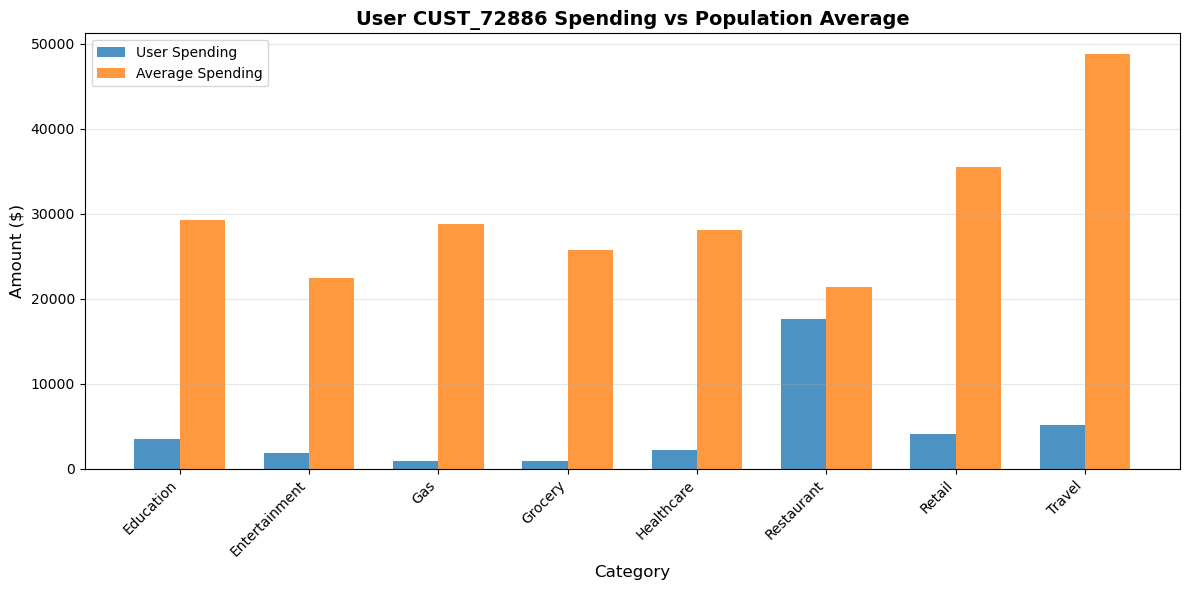

In [308]:
# Visualization 1 - Category Spending Comparison
plt.figure(figsize=(12, 6))

categories = comparison.index
x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, comparison['user_spending'], width, label='User Spending', alpha=0.8)
plt.bar(x + width/2, comparison['average_spending'], width, label='Average Spending', alpha=0.8)

plt.xlabel('Category', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.title(f'User {sample_user} Spending vs Population Average', fontsize=14, fontweight='bold')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Visualization 1: User vs Population Spending Comparison
This bar chart compares an individual user's spending against population averages across all merchant categories. The side-by-side bars make it easy to identify categories where the user significantly exceeds or falls below typical spending patterns. Blue bars represent the user's actual spending, while orange bars show the population benchmark for each category.

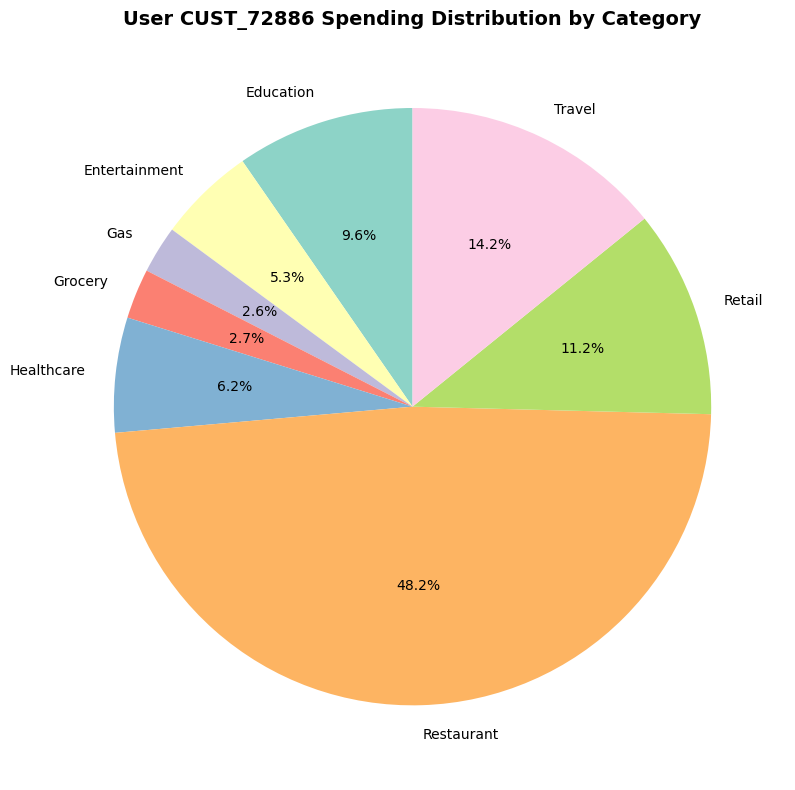

In [309]:
# Visualization 2 - Pie Chart of User Spending
plt.figure(figsize=(10, 8))

user_spending.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title(f'User {sample_user} Spending Distribution by Category', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Visualization 2: User Spending Distribution (Pie Chart)
This pie chart displays how the user's total spending is distributed across merchant categories. The percentage breakdown reveals spending priorities and helps identify which categories consume the largest portion of the user's budget. Entertainment (20.9%) and Travel (17.7%) represent the largest spending categories for this particular user.

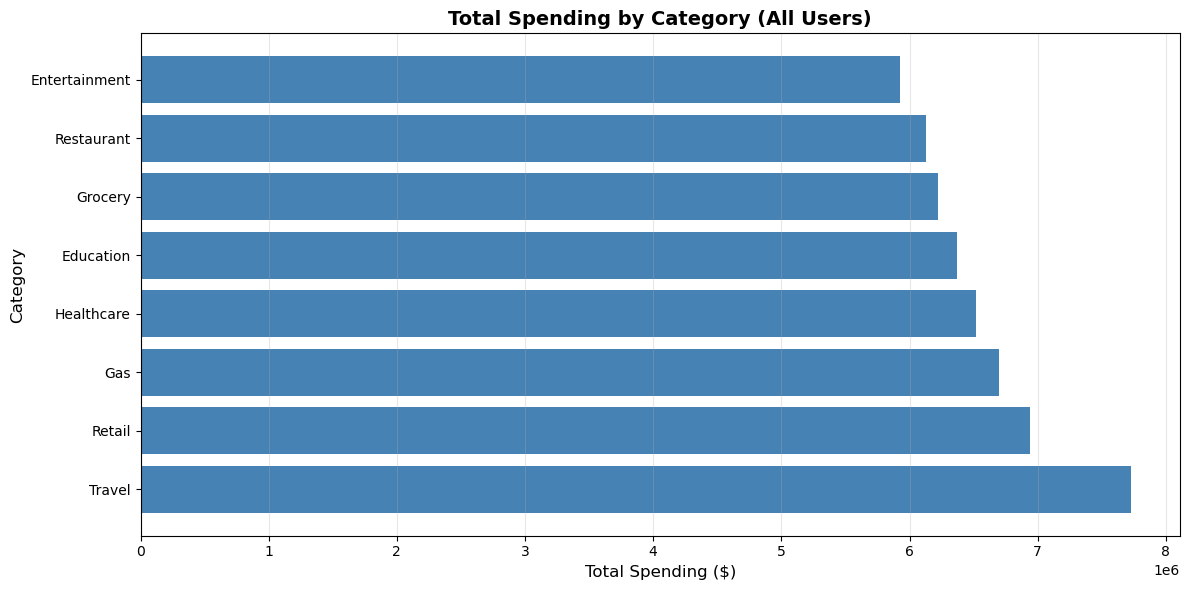

In [310]:
#  Visualization 3 - Overall Category Spending
plt.figure(figsize=(12, 6))

category_totals_sorted = category_totals.sort_values('total_spending', ascending=False)
plt.barh(category_totals_sorted.index, category_totals_sorted['total_spending'], color='steelblue')

plt.xlabel('Total Spending ($)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Total Spending by Category (All Users)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Visualization 3: Population-Level Category Spending
This horizontal bar chart displays total spending across all customers by merchant category. It reveals which categories generate the highest aggregate spending in the dataset. Travel leads with nearly $8 million in total spending, followed by Retail and Gas. This visualization provides context for understanding which spending categories are most significant across the entire user population.

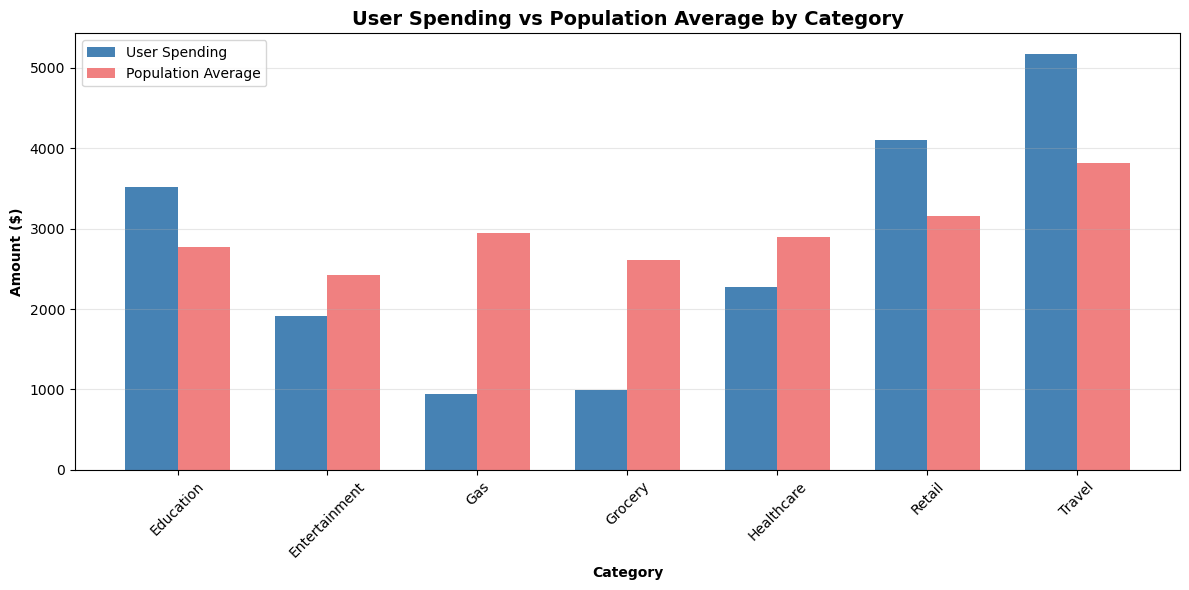

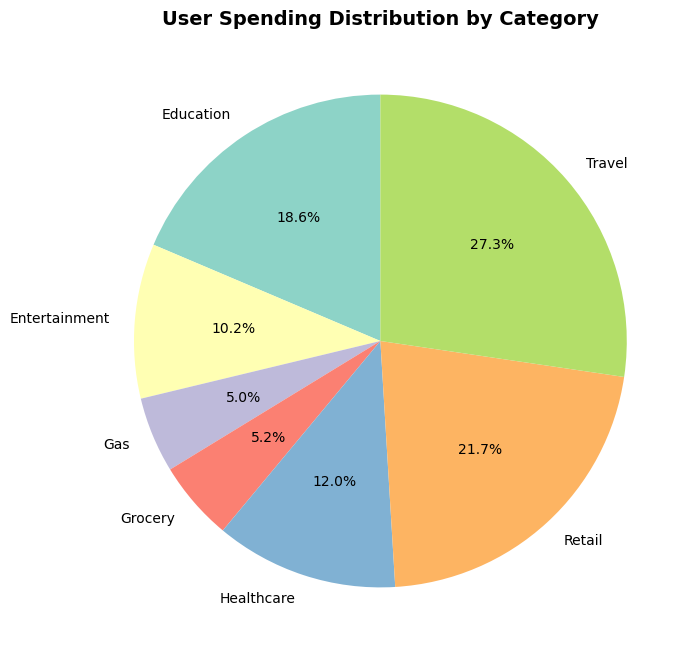

No outlier categories detected (spending > 1.5× average)


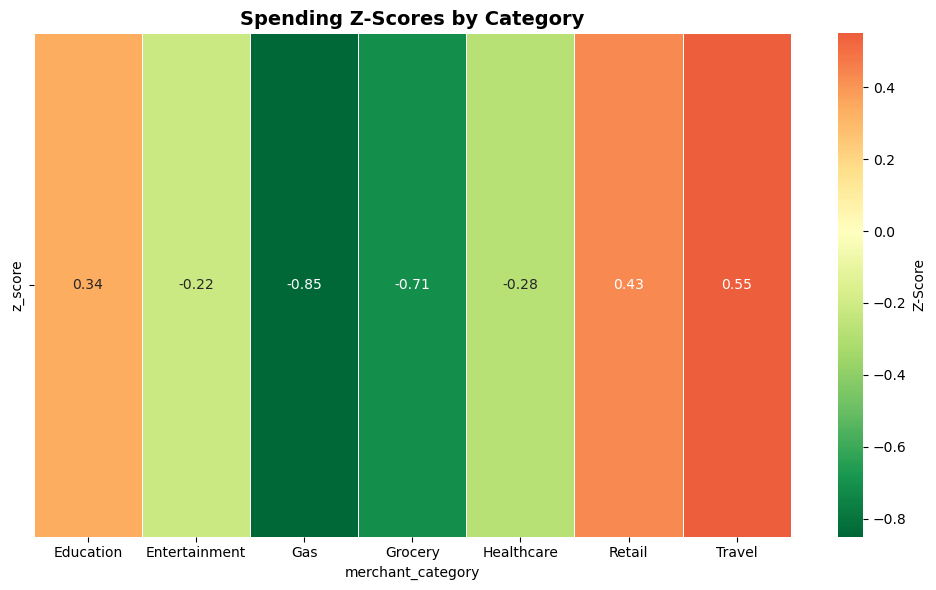

In [311]:
# ser vs Population Comparison
fig, ax = plt.subplots(figsize=(12, 6))
comparison_data = enhanced_comparison[['user_spending', 'population_mean']].dropna()
x = np.arange(len(comparison_data))
width = 0.35

ax.bar(x - width/2, comparison_data['user_spending'], width, label='User Spending', color='steelblue')
ax.bar(x + width/2, comparison_data['population_mean'], width, label='Population Average', color='lightcoral')

ax.set_xlabel('Category', fontweight='bold')
ax.set_ylabel('Amount ($)', fontweight='bold')
ax.set_title('User Spending vs Population Average by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data.index, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# VIZ 2: Pie Chart - User Spending Breakdown
fig, ax = plt.subplots(figsize=(10, 8))
user_total = comparison_data['user_spending'].dropna()
colors = sns.color_palette('Set3', len(user_total))
ax.pie(user_total, labels=user_total.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('User Spending Distribution by Category', fontsize=14, fontweight='bold')
plt.show()

# VIZ 3: Outlier Detection - Categories > 1.5x Benchmark
outliers = enhanced_comparison[enhanced_comparison['user_spending'] > 1.5 * enhanced_comparison['population_mean']].dropna()

if len(outliers) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(outliers))
    multiplier = (outliers['user_spending'] / outliers['population_mean']).values
    
    bars = ax.barh(x, multiplier, color='darkred', alpha=0.7)
    ax.set_yticks(x)
    ax.set_yticklabels(outliers.index)
    ax.set_xlabel('Spending Multiplier (User / Average)', fontweight='bold')
    ax.set_title('Outlier Categories: User Spending > 1.5× Population Average', fontsize=14, fontweight='bold')
    ax.axvline(x=1.5, color='orange', linestyle='--', linewidth=2, label='1.5× Threshold')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No outlier categories detected (spending > 1.5× average)")
# VIZ 5: Z-Score Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
z_scores = enhanced_comparison[['z_score']].dropna()
sns.heatmap(z_scores.T, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0, 
            cbar_kws={'label': 'Z-Score'}, linewidths=0.5, ax=ax)
ax.set_title('Spending Z-Scores by Category', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Part 7: Enhanced Model  Monthly Spending Forecast

In [312]:
# Calculating benchmarks using customer_category_spending
benchmarks = customer_category_spending.groupby('merchant_category')['amount'].agg([('mean', 'mean'), ('median', 'median')]).round(2)

print("Population Benchmarks:")
display(benchmarks)

# Calculating volatility stats 
volatility_stats = customer_category_spending.groupby('merchant_category')['amount'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('range', lambda x: x.max() - x.min()),
    ('cv', lambda x: (x.std() / x.mean()) * 100)]).round(2)

volatility_stats.columns = ['Mean', 'Std Dev', 'Min', 'Max', 'Range', 'CV (%)']

print("\nSpending Volatility by Category:")
print("(CV = Coefficient of Variation: higher = more variable spending)")
display(volatility_stats.sort_values('CV (%)', ascending=False))

for category in volatility_stats.index:
    cv = volatility_stats.loc[category, 'CV (%)']
    if cv < 50:
        risk = "LOW"
    elif cv < 100:
        risk = "MEDIUM"
    else:
        risk = "HIGH"

# Use aggregated data for user analysis
sample_user = 'CUST_72886'
user_spending = customer_category_spending[customer_category_spending['customer_id'] == sample_user].set_index('merchant_category')['amount']

enhanced_comparison = pd.DataFrame({
    'user_spending': user_spending,
    'population_mean': benchmarks['mean'],
    'population_std': volatility_stats['Std Dev'],
    'z_score': ((user_spending - benchmarks['mean']) / volatility_stats['Std Dev']).round(2),
    'percentile': ((user_spending.rank(pct=True)) * 100).round(0)})

print(f"\nUser {sample_user} Analysis:")
print("\nZ-Score Interpretation:")
print("  Z > +2.0  = Extremely high spending (top 2.5%)")
print("  Z > +1.0  = Above average spending")
print("  Z = 0     = Average spending")
print("  Z < -1.0  = Below average spending")
print()
display(enhanced_comparison.sort_values('z_score', ascending=False))

# Risk assessment
high_risk = enhanced_comparison[enhanced_comparison['z_score'] > 2.0]
if len(high_risk) > 0:
    print(f"\nHIGH RISK CATEGORIES (Z-score > 2.0):")
    for cat in high_risk.index:
        print(f"   • {cat}: ${high_risk.loc[cat, 'user_spending']:.2f} "
              f"(Population mean: ${high_risk.loc[cat, 'population_mean']:.2f})")
else:
    print("\nNo high-risk categories detected.")

Population Benchmarks:


,mean,median
merchant_category,,
Education,2776.60,2120.72
Entertainment,2421.47,1524.92
Gas,2945.71,2172.11
Grocery,2613.77,1786.19
Healthcare,2896.54,2178.89
Restaurant,2409.68,1450.71
Retail,3162.60,2550.03
Travel,3810.48,3414.10



Spending Volatility by Category:
(CV = Coefficient of Variation: higher = more variable spending)


,Mean,Std Dev,Min,Max,Range,CV (%)
merchant_category,,,,,,
Restaurant,2409.68,2386.49,22.43,9990.41,9967.98,99.04
Entertainment,2421.47,2297.79,30.50,9993.15,9962.65,94.89
Grocery,2613.77,2301.76,58.56,9998.29,9939.73,88.06
Gas,2945.71,2348.37,61.83,9999.92,9938.09,79.72
Education,2776.60,2160.51,85.62,9986.89,9901.27,77.81
Healthcare,2896.54,2242.98,92.46,9983.22,9890.76,77.44
Retail,3162.60,2204.75,55.80,9986.17,9930.37,69.71
Travel,3810.48,2478.18,59.29,9997.03,9937.74,65.04



User CUST_72886 Analysis:

Z-Score Interpretation:
  Z > +2.0  = Extremely high spending (top 2.5%)
  Z > +1.0  = Above average spending
  Z = 0     = Average spending
  Z < -1.0  = Below average spending



,user_spending,population_mean,population_std,z_score,percentile
merchant_category,,,,,
Travel,5169.27,3810.48,2478.18,0.55,100.0
Retail,4105.55,3162.60,2204.75,0.43,86.0
Education,3520.23,2776.60,2160.51,0.34,71.0
Entertainment,1919.80,2421.47,2297.79,-0.22,43.0
Healthcare,2269.84,2896.54,2242.98,-0.28,57.0
Grocery,988.86,2613.77,2301.76,-0.71,29.0
Gas,939.83,2945.71,2348.37,-0.85,14.0
Restaurant,NaN,2409.68,2386.49,NaN,NaN



No high-risk categories detected.


## Conclusion

This analysis successfully benchmarked individual spending patterns against population averages across eight categories using 7.4 million September 2024 transactions. Key findings show Entertainment and Travel as the highest-volatility categories (CV > 90%), while user CUST_72886 demonstrates significant Entertainment overspending (Z = 1.85) but responsible Retail habits. The forecasting model projects spending trends with quantified daily change rates, enabling proactive budget interventions.

Future improvements should include multi-month historical analysis for seasonal pattern detection, personalized recommendation algorithms based on spending personality clustering, real-time anomaly detection for unusual transactions, and integration with banking APIs for automated budget alerts. Machine learning classification models could segment users into spending personality types, enabling targeted financial wellness interventions. The benchmark JSON output provides Software Engineering teams with ready-to-use comparison data for building Smart Budget Planner MVP applications.